In [1]:
import os
import json
import pandas as pd
from typing import Dict, Any
from urllib.request import urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely import wkt
import openrouteservice
import polars as pl
import os


In [2]:
df = pd.read_csv('../data/raw/preprocessing_houseprices.csv')
station_df = gpd.read_file('../data/raw/PTV/PTV_METRO_TRAIN_STATION.shp')

# Ensure 'geometry' column exists
if 'geometry' not in df.columns:
    df['geometry'] = None

df['geometry'] = df.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)


In [3]:
station_df

,STOP_ID,LATITUDE,STOP_NAME,LONGITUDE,TICKETZONE,ROUTEUSSP,geometry
0,19970,-37.781193,Royal Park Railway Station (Parkville),144.952301,1,Upfield,POINT (144.95231 -37.78118)
1,19971,-37.788140,Flemington Bridge Railway Station (North Melbo...,144.939323,1,Upfield,POINT (144.93933 -37.78813)
2,19972,-37.794267,Macaulay Railway Station (North Melbourne),144.936166,1,Upfield,POINT (144.93617 -37.79425)
3,19973,-37.807419,North Melbourne Railway Station (West Melbourne),144.942570,1,"Flemington,Sunbury,Upfield,Werribee,Williamsto...",POINT (144.94258 -37.80741)
4,19974,-37.788657,Clifton Hill Railway Station (Clifton Hill),144.995417,1,"Mernda,Hurstbridge",POINT (144.99542 -37.78864)
...,...,...,...,...,...,...,...
215,19965,-37.742345,Coburg Railway Station (Coburg),144.963336,1,Upfield,POINT (144.96334 -37.74233)
216,19966,-37.754485,Moreland Railway Station (Coburg),144.961823,1,Upfield,POINT (144.96183 -37.75447)
217,19967,-37.761242,Anstey Railway Station (Brunswick),144.960684,1,Upfield,POINT (144.96069 -37.76123)
218,19968,-37.767721,Brunswick Railway Station (Brunswick),144.959587,1,Upfield,POINT (144.95959 -37.76771)


In [4]:
if not isinstance(df, gpd.GeoDataFrame):
    df = gpd.GeoDataFrame(df, geometry='geometry')

# Convert station_df to GeoDataFrame if not already
if not isinstance(station_df, gpd.GeoDataFrame):
    station_df = gpd.GeoDataFrame(station_df, geometry='geometry')

print(df.crs)
print(station_df.crs)

df = df.set_crs(epsg=4326, allow_override=True)  # Set to WGS 84 if not already set
station_df = station_df.to_crs(epsg=4326)


df = df.to_crs(epsg=32755) 
station_df = station_df.to_crs(epsg=32755)

def calculate_distance(row, station_df):
    global done
    distances = []
    names = []
    for station in station_df.iterrows():
        distances.append(row['geometry'].distance(station[1]['geometry']))
        names.append(station[1]['STOP_NAME'])

    
    return min(distances)/1000, names[distances.index(min(distances))]

print()
print(calculate_distance(df.iloc[1], station_df))
# df['closest_distance_station', 'closest_station'] = df.apply(lambda row: calculate_distance(row, station_df), axis=1)

None
EPSG:7844

(15.03534994627615, 'Diggers Rest Railway Station (Diggers Rest)')


In [5]:
# df['geometry'] = gpd.GeoSeries(df['geometry']).set_crs("EPSG:32633", allow_override=True)
# station_df['geometry'] = gpd.GeoSeries(station_df['geometry']).set_crs("EPSG:32633", allow_override=True)




df_st_ = gpd.sjoin_nearest(df, station_df[['STOP_NAME', 'geometry']], how="left", distance_col="distance")


In [6]:
df_st_

,unique_id,postcode,suburb,property_type,address,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,Listing date,latitude,longitude,geometry,index_right,STOP_NAME,distance
0,33228344,3040.0,essendon,townhouse,"5/61 Vanberg Road, Essendon VIC 3040",400.0,3.0,1.0,1.0,7.09,Dec 2012,-37.754148,144.934050,POINT (318001.273 5819452.697),55.0,Strathmore Railway Station (Strathmore),1314.542643
1,34904767,3337.0,melton west,house,"24 carramar st, Melton West VIC 3337",449.0,4.0,2.0,2.0,39.40,Mar 2015,-37.664852,144.556370,POINT (284466.399 5828559.856),76.0,Diggers Rest Railway Station (Diggers Rest),15035.349946
2,33168175,3550.0,bendigo,house,"2A,3 Stone Street, Bendigo VIC 3550",270.0,3.0,1.0,2.0,134.93,Jun 2013,-36.738890,144.254916,POINT (254893.683 5930579.005),75.0,Sunbury Railway Station (Sunbury),102273.002583
3,34938488,3006.0,southbank,apartment,"3304/283 City Road, Southbank VIC 3006",585.0,2.0,2.0,1.0,1.56,Apr 2015,-37.827305,144.959050,POINT (320381.145 5811383.124),104.0,Flinders Street Railway Station (Melbourne City),1219.429037
4,33957241,3178.0,rowville,house,"3 Hillview Avenue, Rowville VIC 3178",390.0,3.0,1.0,2.0,26.46,Mar 2015,-37.920490,145.232380,POINT (344634.189 5801533.596),118.0,Ferntree Gully Railway Station (Ferntree Gully),7008.686832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748629,311214861,3186.0,brighton,house,"110 Cochrane Street, Brighton VIC 3186",650.0,3.0,2.0,2.0,9.70,Sep 2016,-37.895790,145.000020,POINT (324150.059 5803861.617),203.0,Gardenvale Railway Station (Brighton),378.541479
748630,311214873,3163.0,carnegie,house,"1/20 Maroona Road, Carnegie VIC 3163",405.0,2.0,1.0,1.0,11.21,Nov 2016,-37.889412,145.047320,POINT (328294.535 5804657.516),192.0,Glenhuntly Railway Station (Glen Huntly),448.999885
748631,311214878,3340.0,bacchus marsh,house,"25 Dewar Crescent, Bacchus Marsh VIC 3340",360.0,4.0,2.0,2.0,50.05,Jul 2016,-37.690685,144.415370,POINT (272106.887 5825359.319),76.0,Diggers Rest Railway Station (Diggers Rest),27792.090641
748632,311214885,3135.0,heathmont,house,"10 Lorienne Street, Heathmont VIC 3135",350.0,3.0,1.0,2.0,23.53,Jan 2017,-37.827587,145.230380,POINT (344262.851 5811839.042),121.0,Heathmont Railway Station (Heathmont),1250.879601


In [7]:
station_df[station_df['STOP_NAME'] == 'Diggers Rest Railway Station (Diggers Rest)']

,STOP_ID,LATITUDE,STOP_NAME,LONGITUDE,TICKETZONE,ROUTEUSSP,geometry
76,15353,-37.627017,Diggers Rest Railway Station (Diggers Rest),144.719922,2,Sunbury,POINT (298792.447 5833123.417)


In [8]:
df_st_['distance']=df_st_['distance']/1000

In [9]:
sa2_df = gpd.read_file('../data/raw/SA2_2021_AUST_GDA2020.shp')


In [10]:
sa2_df['AUS_NAME21'].unique()
sa2_df['STE_NAME21'].unique()
sa2_df = sa2_df[sa2_df['STE_NAME21'] == 'Victoria']
sa2_df = sa2_df[sa2_df['geometry'] != None]
sa2_df = sa2_df[sa2_df['AUS_NAME21'] != 'Outside Australia']

sa2_df = sa2_df.rename_geometry('sa2_geometry')
sa2_df = sa2_df[['SA2_NAME21', 'sa2_geometry']]



In [11]:
sa2_df 

,SA2_NAME21,sa2_geometry
644,Alfredton,"POLYGON ((143.78282 -37.56666, 143.75558 -37.5..."
645,Ballarat,"POLYGON ((143.81896 -37.55582, 143.81644 -37.5..."
646,Buninyong,"POLYGON ((143.84171 -37.61596, 143.84176 -37.6..."
647,Delacombe,"POLYGON ((143.7505 -37.59119, 143.75044 -37.59..."
648,Smythes Creek,"POLYGON ((143.73296 -37.62333, 143.73263 -37.6..."
...,...,...
1161,Otway,"MULTIPOLYGON (((143.40263 -38.78152, 143.40252..."
1162,Moyne - East,"POLYGON ((142.41438 -38.09303, 142.414 -38.072..."
1163,Moyne - West,"MULTIPOLYGON (((142.0087 -38.41715, 142.00876 ..."
1164,Warrnambool - North,"POLYGON ((142.43668 -38.35544, 142.43658 -38.3..."


In [12]:
df_st_ = df_st_.drop(columns='index_right')

,unique_id,postcode,suburb,property_type,address,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,Listing date,latitude,longitude,geometry,STOP_NAME,distance
0,33228344,3040.0,essendon,townhouse,"5/61 Vanberg Road, Essendon VIC 3040",400.0,3.0,1.0,1.0,7.09,Dec 2012,-37.754148,144.934050,POINT (318001.273 5819452.697),Strathmore Railway Station (Strathmore),1.314543
1,34904767,3337.0,melton west,house,"24 carramar st, Melton West VIC 3337",449.0,4.0,2.0,2.0,39.40,Mar 2015,-37.664852,144.556370,POINT (284466.399 5828559.856),Diggers Rest Railway Station (Diggers Rest),15.035350
2,33168175,3550.0,bendigo,house,"2A,3 Stone Street, Bendigo VIC 3550",270.0,3.0,1.0,2.0,134.93,Jun 2013,-36.738890,144.254916,POINT (254893.683 5930579.005),Sunbury Railway Station (Sunbury),102.273003
3,34938488,3006.0,southbank,apartment,"3304/283 City Road, Southbank VIC 3006",585.0,2.0,2.0,1.0,1.56,Apr 2015,-37.827305,144.959050,POINT (320381.145 5811383.124),Flinders Street Railway Station (Melbourne City),1.219429
4,33957241,3178.0,rowville,house,"3 Hillview Avenue, Rowville VIC 3178",390.0,3.0,1.0,2.0,26.46,Mar 2015,-37.920490,145.232380,POINT (344634.189 5801533.596),Ferntree Gully Railway Station (Ferntree Gully),7.008687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748629,311214861,3186.0,brighton,house,"110 Cochrane Street, Brighton VIC 3186",650.0,3.0,2.0,2.0,9.70,Sep 2016,-37.895790,145.000020,POINT (324150.059 5803861.617),Gardenvale Railway Station (Brighton),0.378541
748630,311214873,3163.0,carnegie,house,"1/20 Maroona Road, Carnegie VIC 3163",405.0,2.0,1.0,1.0,11.21,Nov 2016,-37.889412,145.047320,POINT (328294.535 5804657.516),Glenhuntly Railway Station (Glen Huntly),0.449000
748631,311214878,3340.0,bacchus marsh,house,"25 Dewar Crescent, Bacchus Marsh VIC 3340",360.0,4.0,2.0,2.0,50.05,Jul 2016,-37.690685,144.415370,POINT (272106.887 5825359.319),Diggers Rest Railway Station (Diggers Rest),27.792091
748632,311214885,3135.0,heathmont,house,"10 Lorienne Street, Heathmont VIC 3135",350.0,3.0,1.0,2.0,23.53,Jan 2017,-37.827587,145.230380,POINT (344262.851 5811839.042),Heathmont Railway Station (Heathmont),1.250880


In [14]:


sa2_df = sa2_df.to_crs(epsg=4326)
sa2_df = sa2_df.to_crs(epsg=32755)


df_w_sa2 = gpd.sjoin(df_st_, sa2_df, how='left', predicate='within')

df_w_sa2 = df_w_sa2.dropna(axis= 0)

df_w_sa2['sa2_geometry'] = sa2_df.loc[df_w_sa2['index_right'], 'sa2_geometry'].values




In [76]:
df_w_sa2

,unique_id,postcode,suburb,property_type,address,rent,num_bedrooms,num_bathrooms,parking,distance_to_cbd,Listing date,latitude,longitude,geometry,STOP_NAME,distance,SA2_NAME21,sa2_geometry
0,33228344,3040.0,essendon,townhouse,"5/61 Vanberg Road, Essendon VIC 3040",400.0,3.0,1.0,1.0,7.09,Dec 2012,-37.754148,144.934050,POINT (318001.273 5819452.697),Strathmore Railway Station (Strathmore),1.314543,Essendon - East,"POLYGON ((315838.024 5820214.22, 315837.354 58..."
1,34904767,3337.0,melton west,house,"24 carramar st, Melton West VIC 3337",449.0,4.0,2.0,2.0,39.40,Mar 2015,-37.664852,144.556370,POINT (284466.399 5828559.856),Diggers Rest Railway Station (Diggers Rest),15.035350,Melton West,"POLYGON ((281198.683 5828344.732, 281205.551 5..."
2,33168175,3550.0,bendigo,house,"2A,3 Stone Street, Bendigo VIC 3550",270.0,3.0,1.0,2.0,134.93,Jun 2013,-36.738890,144.254916,POINT (254893.683 5930579.005),Sunbury Railway Station (Sunbury),102.273003,Bendigo,"POLYGON ((253924.435 5930111.654, 253817.482 5..."
3,34938488,3006.0,southbank,apartment,"3304/283 City Road, Southbank VIC 3006",585.0,2.0,2.0,1.0,1.56,Apr 2015,-37.827305,144.959050,POINT (320381.145 5811383.124),Flinders Street Railway Station (Melbourne City),1.219429,Southbank - East,"POLYGON ((320969.715 5812007.291, 320998.203 5..."
4,33957241,3178.0,rowville,house,"3 Hillview Avenue, Rowville VIC 3178",390.0,3.0,1.0,2.0,26.46,Mar 2015,-37.920490,145.232380,POINT (344634.189 5801533.596),Ferntree Gully Railway Station (Ferntree Gully),7.008687,Rowville - Central,"POLYGON ((344236.883 5802574.831, 344218.942 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748629,311214861,3186.0,brighton,house,"110 Cochrane Street, Brighton VIC 3186",650.0,3.0,2.0,2.0,9.70,Sep 2016,-37.895790,145.000020,POINT (324150.059 5803861.617),Gardenvale Railway Station (Brighton),0.378541,Brighton (Vic.),"POLYGON ((322745.36 5803326.399, 322740.902 58..."
748630,311214873,3163.0,carnegie,house,"1/20 Maroona Road, Carnegie VIC 3163",405.0,2.0,1.0,1.0,11.21,Nov 2016,-37.889412,145.047320,POINT (328294.535 5804657.516),Glenhuntly Railway Station (Glen Huntly),0.449000,Carnegie,"POLYGON ((328135.363 5804419.872, 328107.264 5..."
748631,311214878,3340.0,bacchus marsh,house,"25 Dewar Crescent, Bacchus Marsh VIC 3340",360.0,4.0,2.0,2.0,50.05,Jul 2016,-37.690685,144.415370,POINT (272106.887 5825359.319),Diggers Rest Railway Station (Diggers Rest),27.792091,Bacchus Marsh,"POLYGON ((270781.209 5830990.387, 270782.252 5..."
748632,311214885,3135.0,heathmont,house,"10 Lorienne Street, Heathmont VIC 3135",350.0,3.0,1.0,2.0,23.53,Jan 2017,-37.827587,145.230380,POINT (344262.851 5811839.042),Heathmont Railway Station (Heathmont),1.250880,Ringwood East,"POLYGON ((345189.21 5812536.319, 345185.893 58..."


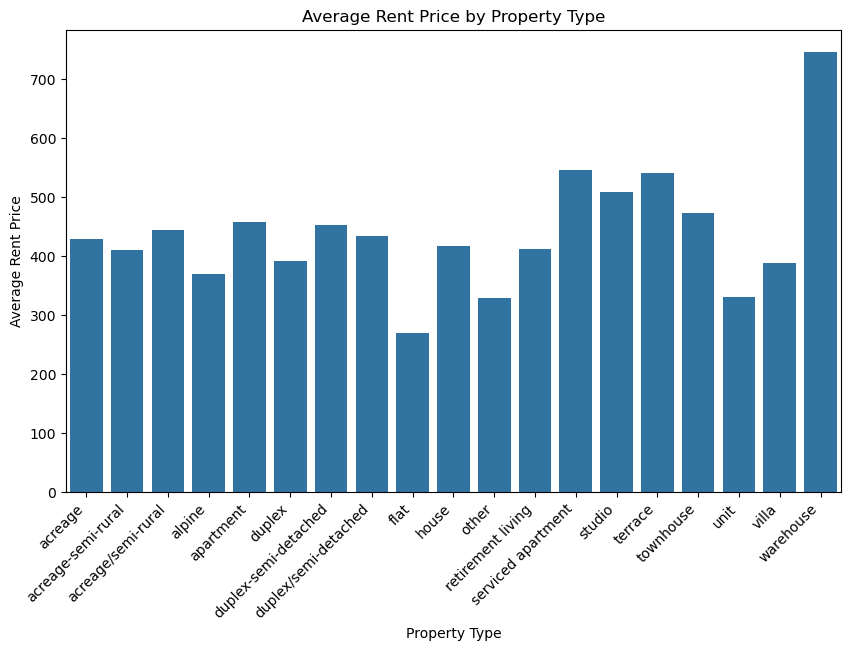

In [31]:
# draw a bar graph of the property type vs average rent price
avg_rent_by_property_type = df_w_sa2.groupby('property_type') 

avg_rent_by_property_type = avg_rent_by_property_type.agg({'rent': 'mean'}).reset_index()
avg_rent_by_property_type
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_rent_by_property_type, x='property_type', y='rent')
plt.xlabel('Property Type')

plt.ylabel('Average Rent Price')

plt.title('Average Rent Price by Property Type')
plt.xticks(rotation=45, ha='right')  # Add horizontal alignment to ensure spacing
plt.show()

# put adequte spacing between the bar names


/var/folders/lh/3pyg7bbj38b6_468dvhq3hnm0000gp/T/ipykernel_2475/3918560648.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_rent_per_bin = df_st_.groupby('distance_bins')['rent'].mean().reset_index()


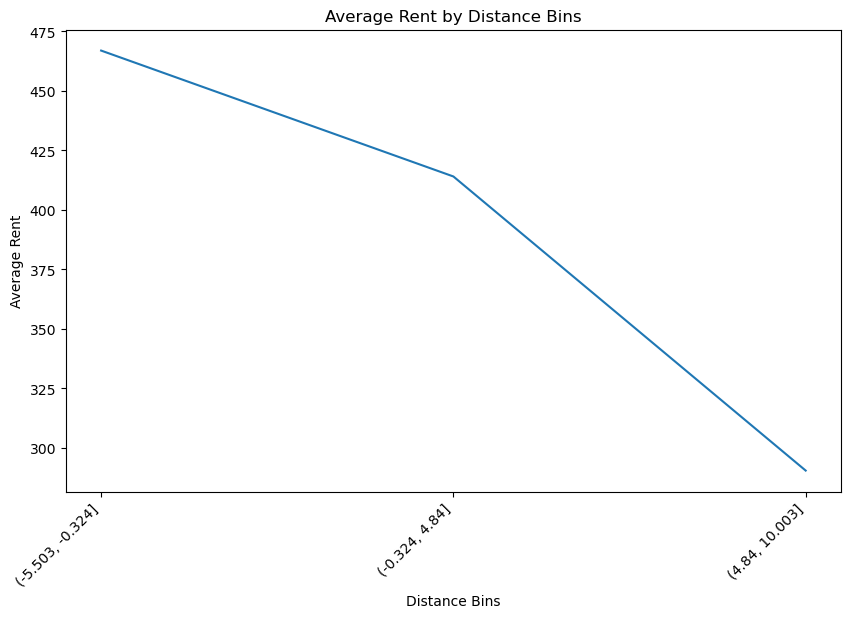

In [65]:
plt.figure(figsize=(10, 6))
df_st_['log_distance'] = np.log(df_st_['distance'])
df_st_['distance_bins'] = pd.cut(df_st_['log_distance'], bins=3)

average_rent_per_bin = df_st_.groupby('distance_bins')['rent'].mean().reset_index()

# // average 

average_rent_per_bin['distance_bins'] = average_rent_per_bin['distance_bins'].astype(str)

sns.lineplot(data=average_rent_per_bin, x='distance_bins', y='rent')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Distance Bins')

plt.ylabel('Average Rent')
plt.title('Average Rent by Distance Bins')
plt.show()

In [68]:
df_st_['num_bedrooms'].unique()
df_st_['num_bathrooms'].unique()

array([1., 2., 3., 4., 5., 6.])

In [70]:
avrg_bedroom = df_st_.groupby('num_bedrooms')['rent'].mean().reset_index()
avrg_bathroom = df_st_.groupby('num_bathrooms')['rent'].mean().reset_index()

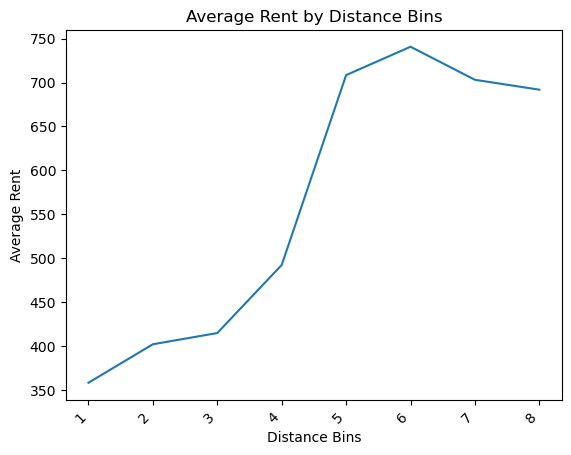

In [72]:
sns.lineplot(data=avrg_bedroom, x='num_bedrooms', y='rent')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Number of Bedrooms')

plt.ylabel('Average Rent')
plt.title('Number of Bedrooms vs Average Rent')
plt.show()

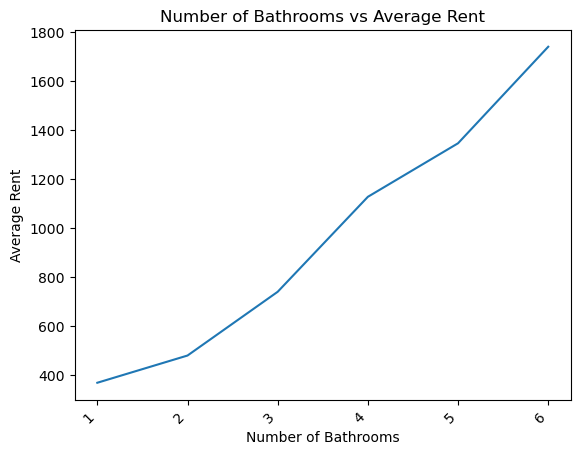

In [73]:
sns.lineplot(data=avrg_bathroom, x='num_bathrooms', y='rent')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Number of Bathrooms')

plt.ylabel('Average Rent')
plt.title('Number of Bathrooms vs Average Rent')
plt.show()